### Lab | Making predictions with logistic regression
Antonio Montilla

In [1]:
#Importing libraries
import pandas as pd
import numpy as np

import pymysql                        # for getting data from a SQL database
from sqlalchemy import create_engine  # for establishing the connection and authentication

import getpass  # To get the password without showing the input
password = getpass.getpass()

········


#### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X). ###

In [2]:
# making the connection with sakila database
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
#First I will import the 'film' table but joining with 'film_category' table:
query = '''SELECT * FROM film LEFT JOIN film_category USING (film_id);'''

films = pd.read_sql_query(query, engine)

display(films.head())
display(films.shape)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,category_id,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,6,2006-02-15 05:07:09
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42,11,2006-02-15 05:07:09
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2006-02-15 05:03:42,6,2006-02-15 05:07:09
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2006-02-15 05:03:42,11,2006-02-15 05:07:09
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2006-02-15 05:03:42,8,2006-02-15 05:07:09


(1000, 15)

In [4]:
#Now I will import the 'rental' table joining with 'inventory' table and restricting to films rented in May(so I can get film_id)
query = '''SELECT * FROM rental LEFT JOIN inventory USING (inventory_id) WHERE MONTH(rental_date) = 5;'''

rentals = pd.read_sql_query(query, engine)

display(rentals.head())
display(rentals.shape)

,inventory_id,rental_id,rental_date,customer_id,return_date,staff_id,last_update,film_id,store_id,last_update
0,367,1,2005-05-24 22:53:30,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53,80,1,2006-02-15 05:09:17
1,1525,2,2005-05-24 22:54:33,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53,333,2,2006-02-15 05:09:17
2,1711,3,2005-05-24 23:03:39,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53,373,2,2006-02-15 05:09:17
3,2452,4,2005-05-24 23:04:41,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53,535,1,2006-02-15 05:09:17
4,2079,5,2005-05-24 23:05:21,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53,450,2,2006-02-15 05:09:17


(1156, 10)

####  2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable. ####

#### 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose. ####

In [5]:
#I will use the data already imported in step 1 and the following: 
# 1. (left) pd.merging df 'films' with df 'rentals'
data = films.merge(rentals, on = "film_id", how = 'left')
display(data.head())
display(data.columns)
display(data.shape)


,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,...,last_update_x,inventory_id,rental_id,rental_date,customer_id,return_date,staff_id,last_update_y,store_id,last_update_y
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,...,2006-02-15 05:07:09,6.0,361.0,2005-05-27 07:03:28,587.0,2005-05-31 08:01:28,1.0,2006-02-15 21:30:53,2.0,2006-02-15 05:09:17
1,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,...,2006-02-15 05:07:09,2.0,972.0,2005-05-30 20:21:07,411.0,2005-06-06 00:36:07,1.0,2006-02-15 21:30:53,1.0,2006-02-15 05:09:17
2,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,...,2006-02-15 05:07:09,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
3,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,...,2006-02-15 05:07:09,14.0,1033.0,2005-05-31 04:50:07,25.0,2005-06-02 01:53:07,1.0,2006-02-15 21:30:53,2.0,2006-02-15 05:09:17
4,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,...,2006-02-15 05:07:09,20.0,465.0,2005-05-27 20:44:36,261.0,2005-06-02 02:43:36,1.0,2006-02-15 21:30:53,2.0,2006-02-15 05:09:17


Index(['film_id', 'title', 'description', 'release_year', 'language_id',
       'original_language_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'special_features', 'last_update_x',
       'category_id', 'last_update_x', 'inventory_id', 'rental_id',
       'rental_date', 'customer_id', 'return_date', 'staff_id',
       'last_update_y', 'store_id', 'last_update_y'],
      dtype='object')

(1470, 24)

In [6]:
data['film_id'].nunique()

1000

In [80]:
# 2. dropping the columns that will certainly not be used in the model
col_ex = ['title', 'description', 'release_year', 'language_id', 'original_language_id', 'last_update_x', 'last_update_x', 'inventory_id', 'rental_id', 'customer_id', 'return_date', 'last_update_y', 'store_id', 'staff_id']
data2 =data.drop(col_ex, axis = 1)
display(data2.head(30))
display(data2.columns)
display(data2.shape)

,film_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_id,rental_date
0,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",6,2005-05-27 07:03:28
1,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",6,2005-05-30 20:21:07
2,2,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",11,NaT
3,3,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",6,2005-05-31 04:50:07
4,4,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",11,2005-05-27 20:44:36
5,4,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",11,2005-05-31 00:06:02
6,5,6,2.99,130,22.99,G,Deleted Scenes,8,2005-05-28 07:53:38
7,6,3,2.99,169,17.99,PG,Deleted Scenes,9,2005-05-26 15:32:46
8,6,3,2.99,169,17.99,PG,Deleted Scenes,9,2005-05-26 23:23:56
9,7,6,4.99,62,28.99,PG-13,"Trailers,Deleted Scenes",5,NaT


Index(['film_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'special_features', 'category_id',
       'rental_date'],
      dtype='object')

(1470, 9)

In [81]:
# 3. creating the target column from rental_date (if rental_date in May then rented_in_may == true)
data2['month'] = data2['rental_date'].dt.month
data2['rented_in_may'] = np.where(data2['month'] == 5, 1, 0)
data2.head(10)

,film_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_id,rental_date,month,rented_in_may
0,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",6,2005-05-27 07:03:28,5.0,1
1,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",6,2005-05-30 20:21:07,5.0,1
2,2,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",11,NaT,NaN,0
3,3,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",6,2005-05-31 04:50:07,5.0,1
4,4,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",11,2005-05-27 20:44:36,5.0,1
5,4,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",11,2005-05-31 00:06:02,5.0,1
6,5,6,2.99,130,22.99,G,Deleted Scenes,8,2005-05-28 07:53:38,5.0,1
7,6,3,2.99,169,17.99,PG,Deleted Scenes,9,2005-05-26 15:32:46,5.0,1
8,6,3,2.99,169,17.99,PG,Deleted Scenes,9,2005-05-26 23:23:56,5.0,1
9,7,6,4.99,62,28.99,PG-13,"Trailers,Deleted Scenes",5,NaT,NaN,0


In [82]:
# 4. dropping additional columns and deleting duplicates
data2 =data2.drop(['rental_date', 'month'], axis = 1)
data2 = data2.drop_duplicates()
data2 = data2.reset_index(drop=True)
display(data2.head())
display(data2.shape)

,film_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_id,rented_in_may
0,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",6,1
1,2,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",11,0
2,3,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",6,1
3,4,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",11,1
4,5,6,2.99,130,22.99,G,Deleted Scenes,8,1


(1000, 9)

In [83]:
#checking the distribution of target column 'rented_in_may'
data2['rented_in_may'].value_counts()

1    686
0    314
Name: rented_in_may, dtype: int64

#### 4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables. ####

In [84]:
#First looking into types and basic data from the df
display(data2.dtypes)

film_id               int64
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
special_features     object
category_id           int64
rented_in_may         int64
dtype: object

In [85]:
#For the model I will also drop the column 'film_id'
data2 = data2.drop(['film_id'], axis = 1)

In [86]:
display(data2.head())
display(data2.dtypes)
display(data2.describe().T)

,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_id,rented_in_may
0,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",6,1
1,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",11,0
2,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",6,1
3,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",11,1
4,6,2.99,130,22.99,G,Deleted Scenes,8,1


rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
special_features     object
category_id           int64
rented_in_may         int64
dtype: object

,count,mean,std,min,25%,50%,75%,max
rental_duration,1000.0,4.985,1.411654,3.00,4.00,5.00,6.00,7.00
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00
replacement_cost,1000.0,19.984,6.050833,9.99,14.99,19.99,24.99,29.99
category_id,1000.0,8.478,4.610290,1.00,5.00,8.00,13.00,16.00
rented_in_may,1000.0,0.686,0.464349,0.00,0.00,1.00,1.00,1.00


In [87]:
#Looking first at sum of NaNs
data2.isna().sum()

rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
special_features    0
category_id         0
rented_in_may       0
dtype: int64

In [88]:
#Now looking column by column
#rental_duration
data2['rental_duration'].value_counts()

6    212
3    203
4    203
7    191
5    191
Name: rental_duration, dtype: int64

In [89]:
#From the information, will convert 'rental_duration' to a categorical variable
data2['rental_duration'] = data2['rental_duration'].astype('object')

In [90]:
#rental_rate
data2['rental_rate'].value_counts()

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64

In [91]:
#From the information, will also convert 'rental_rate' to a categorical variable
data2['rental_rate'] = data2['rental_rate'].astype('object')

/var/folders/ws/0xbhg9d95hd9g5nvrfz8pwk40000gn/T/ipykernel_25769/2487377327.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data2['length'])


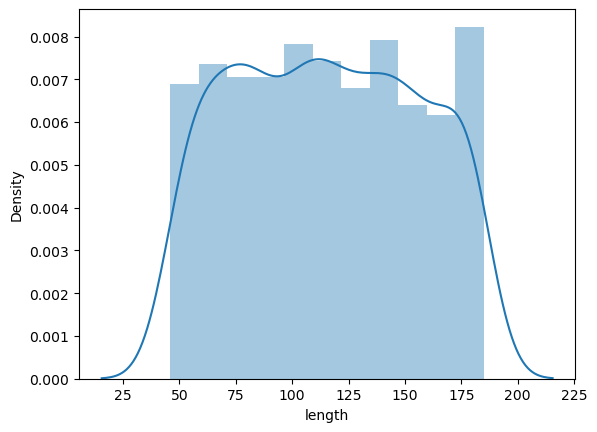

In [92]:
#length 
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(data2['length'])
plt.show()
#will keep length as numerical variable

/var/folders/ws/0xbhg9d95hd9g5nvrfz8pwk40000gn/T/ipykernel_25769/3079626939.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data2['replacement_cost'])


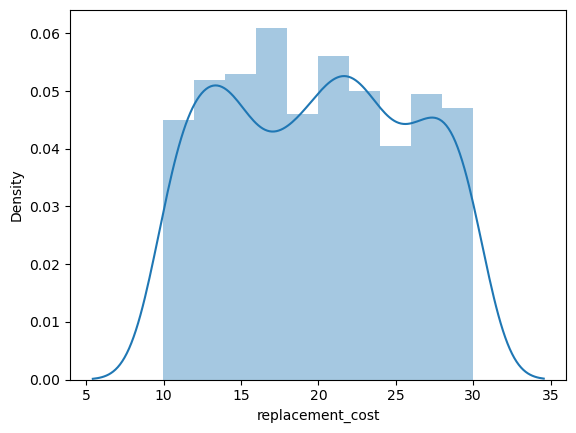

20.99    57
22.99    55
12.99    55
21.99    55
13.99    55
27.99    53
29.99    53
14.99    51
19.99    50
10.99    49
11.99    49
17.99    47
26.99    46
23.99    45
25.99    43
18.99    42
28.99    41
9.99     41
24.99    38
16.99    38
15.99    37
Name: replacement_cost, dtype: int64

In [93]:
#replacement_cost
sns.distplot(data2['replacement_cost'])
plt.show()
data2['replacement_cost'].value_counts()
#will also keep replacement_cost as numerical variable

In [94]:
#rating
data2['rating'].value_counts()
#categorical variable, will keep it as such

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [95]:
#category_id
data2['category_id'].value_counts()
#will keep category_id as numerical variable, even if it looks as it could be categorical

15    74
9     73
8     69
6     68
2     66
1     64
13    63
7     62
14    61
10    61
3     60
5     58
4     57
16    57
11    56
12    51
Name: category_id, dtype: int64

In [96]:
#special_features
data2['special_features'].value_counts()
#for this column I want to create 4 dummy columns ("Trailers", "Commentaries", "Deleted Scenes", "Behind the Scenes") that will take 1 if it is listed in the row

Trailers,Commentaries,Behind the Scenes                   79
Trailers                                                  72
Trailers,Commentaries                                     72
Trailers,Behind the Scenes                                72
Deleted Scenes,Behind the Scenes                          71
Commentaries,Behind the Scenes                            70
Behind the Scenes                                         70
Trailers,Deleted Scenes                                   66
Commentaries,Deleted Scenes,Behind the Scenes             66
Commentaries,Deleted Scenes                               65
Trailers,Commentaries,Deleted Scenes                      64
Commentaries                                              62
Deleted Scenes                                            61
Trailers,Commentaries,Deleted Scenes,Behind the Scenes    61
Trailers,Deleted Scenes,Behind the Scenes                 49
Name: special_features, dtype: int64

In [97]:
# Define the list of categories
categories = ["Trailers", "Commentaries", "Deleted Scenes", "Behind the Scenes"]
# Create dummy columns
for category in categories:
    data2[category] = data2['special_features'].str.contains(category).astype(int)
    
#dropping 'special_features'
data2 = data2.drop('special_features', axis=1)
data2.head()

,rental_duration,rental_rate,length,replacement_cost,rating,category_id,rented_in_may,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
0,6,0.99,86,20.99,PG,6,1,0,0,1,1
1,3,4.99,48,12.99,G,11,0,1,0,1,0
2,7,2.99,50,18.99,NC-17,6,1,1,0,1,0
3,5,2.99,117,26.99,G,11,1,0,1,0,1
4,6,2.99,130,22.99,G,8,1,0,0,1,0


In [98]:
#declaring the new variables as object
data2['Trailers'] = data2['Trailers'].astype('object')
data2['Commentaries'] = data2['Commentaries'].astype('object')
data2['Deleted Scenes'] = data2['Deleted Scenes'].astype('object')
data2['Behind the Scenes'] = data2['Behind the Scenes'].astype('object')

In [99]:
display(data2.isna().sum())
display(data2.dtypes)

rental_duration      0
rental_rate          0
length               0
replacement_cost     0
rating               0
category_id          0
rented_in_may        0
Trailers             0
Commentaries         0
Deleted Scenes       0
Behind the Scenes    0
dtype: int64

rental_duration       object
rental_rate           object
length                 int64
replacement_cost     float64
rating                object
category_id            int64
rented_in_may          int64
Trailers              object
Commentaries          object
Deleted Scenes        object
Behind the Scenes     object
dtype: object

In [100]:
# Now, will X-y split and train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = data2['rented_in_may']
X = data2.drop('rented_in_may', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
X_train.dtypes

rental_duration       object
rental_rate           object
length                 int64
replacement_cost     float64
rating                object
category_id            int64
Trailers              object
Commentaries          object
Deleted Scenes        object
Behind the Scenes     object
dtype: object

In [102]:
# split numericals and categoricals

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat  = X_test.select_dtypes(include = object)

In [103]:
#scaling X_train_num
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(X_train_num) # we will reuse this transformer for X_test later
X_train_scaled_arr = transformer.transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X_train_num.columns)
X_train_scaled.head()

,length,replacement_cost,category_id
0,0.258993,0.90,0.666667
1,0.136691,0.45,0.200000
2,0.489209,0.55,0.066667
3,0.179856,0.45,0.800000
4,0.280576,0.50,0.266667


In [104]:
X_train.isna().sum()

rental_duration      0
rental_rate          0
length               0
replacement_cost     0
rating               0
category_id          0
Trailers             0
Commentaries         0
Deleted Scenes       0
Behind the Scenes    0
dtype: int64

In [105]:
# encode categoricals
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat = encoder.transform(X_train_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
onehot_encoded = pd.DataFrame(encoded_cat, columns=cols)
onehot_encoded

,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R,Trailers_1,Commentaries_1,Deleted Scenes_1,Behind the Scenes_1
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
796,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
797,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
798,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [106]:
onehot_encoded.isna().sum()

rental_duration_4      0
rental_duration_5      0
rental_duration_6      0
rental_duration_7      0
rental_rate_2.99       0
rental_rate_4.99       0
rating_NC-17           0
rating_PG              0
rating_PG-13           0
rating_R               0
Trailers_1             0
Commentaries_1         0
Deleted Scenes_1       0
Behind the Scenes_1    0
dtype: int64

In [107]:
#Concatenate X
X_train_treated = pd.concat([X_train_scaled, onehot_encoded], axis=1)

In [108]:
X_train_treated.isna().sum()

length                 0
replacement_cost       0
category_id            0
rental_duration_4      0
rental_duration_5      0
rental_duration_6      0
rental_duration_7      0
rental_rate_2.99       0
rental_rate_4.99       0
rating_NC-17           0
rating_PG              0
rating_PG-13           0
rating_R               0
Trailers_1             0
Commentaries_1         0
Deleted Scenes_1       0
Behind the Scenes_1    0
dtype: int64

#### 4. Create a logistic regression model to predict 'rented_in_may' from the cleaned data. ####

In [109]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression()
classification.fit(X_train_treated, y_train)

LogisticRegression()

#### 5. Evaluate the results. ####

In [110]:
#Will first transform X_test
X_test_num.head()

,length,replacement_cost,category_id
521,137,9.99,5
737,178,27.99,9
740,81,28.99,12
660,157,17.99,9
411,102,25.99,6


In [111]:
# apply scaler to X_test_num
X_test_scaled_arr = transformer.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test_num.columns)
X_test_scaled.head(30)

,length,replacement_cost,category_id
0,0.654676,0.00,0.266667
1,0.949640,0.90,0.533333
2,0.251799,0.95,0.733333
3,0.798561,0.40,0.533333
4,0.402878,0.80,0.333333
5,0.028777,0.40,0.466667
6,0.151079,0.00,0.333333
7,0.165468,0.40,0.400000
8,0.338129,0.20,0.866667
9,0.143885,0.60,0.866667


In [112]:
# apply encoder to X_test_cat
encoded_test_cat = encoder.transform(X_test_cat).toarray()
onehot_encoded_test = pd.DataFrame(encoded_test_cat, columns=cols)
onehot_encoded_test.head()

,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R,Trailers_1,Commentaries_1,Deleted Scenes_1,Behind the Scenes_1
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [113]:
# combine scaled and onehot_encoded portions of X_test
X_test_treated = pd.concat([X_test_scaled, onehot_encoded_test], axis=1)

In [114]:
predictions = classification.predict(X_test_treated)
predictions
classification.score(X_test_treated, y_test)

0.68

In [ ]:
#accuracy score of 68%, but will be good to see confusion_matrix to check how that accuracy is distributed

In [115]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  2,  63],
       [  1, 134]])

In [116]:
y_test.value_counts()

1    135
0     65
Name: rented_in_may, dtype: int64

In [ ]:
#The results suggest the model may be biased in estimating films that are not rented (134 out of the 200 observations in the test data) and barely estimate those that get indeed rented (only 2 in the test data)